In [246]:
%matplotlib inline
%env THEANO_FLAGS=device=cpu,floatX=float32
import theano

import pymc3 as pm
from pymc3 import Normal, Metropolis, sample, MvNormal, Dirichlet, \
    DensityDist, find_MAP, NUTS, Slice
import theano.tensor as tt
from theano.tensor.nlinalg import det
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as st

from pymc3.math import logsumexp
from scipy.special import logsumexp as sp_logsumexp
from pymc3.distributions.dist_math import rho2sd

%config InlineBackend.figure_format = 'retina'
plt.style.use('ggplot')

env: THEANO_FLAGS=device=cpu,floatX=float32


# Data

In [247]:
def build_toy_dataset(N, K):
    pi = np.array([0.2, 0.5, 0.3])
    mus = [[1, 1], [-1, -1], [2,-2]]
    stds = [[0.1, 0.1], [0.1, 0.2], [0.2, 0.3]]
    x = np.zeros((N, 2), dtype=np.float32)
    y = np.zeros((N,), dtype=np.int)
    for n in range(N):
        k = np.argmax(np.random.multinomial(1, pi))
        x[n, :] = np.random.multivariate_normal(mus[k], np.diag(stds[k]))
        y[n] = k

    return x,y

N = 500  # number of data points
D = 2  # dimensionality of data

X, y = build_toy_dataset(N, 3)


In [248]:
X.shape

(500, 2)

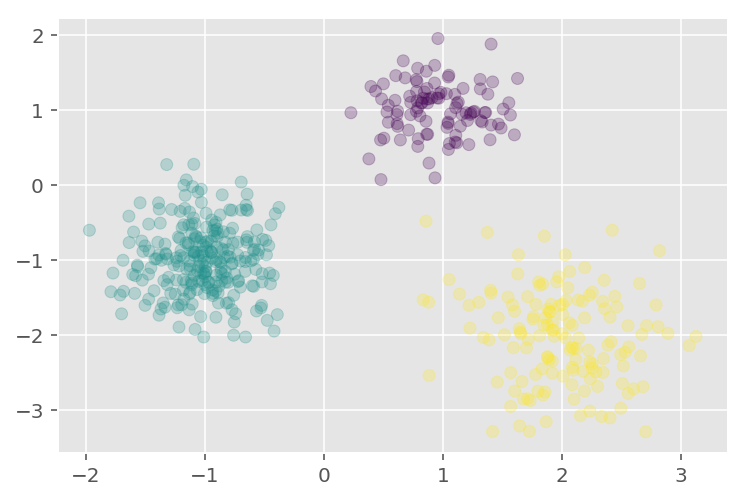

In [250]:
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.viridis, alpha=.25)

# Model

$p(x_n | \pi, \mu, \sigma) = \sum_{i=1}^K \pi_k \text{Normal}(x_n | \mu_k, \sigma^2_k)$

$p(\pi) = \text{Dirichlet} (\pi | \alpha \mathbf{1}_k)$

$p(\mu_k) = \text{Normal}(0,I)$

$p(\Sigma_k ) = \text{LKJ} (\Sigma | \eta,sd) $

In [252]:
# set up model
K = 3
with pm.Model() as model:
    pi = pm.Dirichlet('pi', np.ones(K))

    comp_dist = []
    mu = []
    packed_chol = []
    chol = []
    for i in range(K):
        mu.append(pm.Normal('mu%i'%i, 0, 10, shape=2))
        packed_chol.append(pm.LKJCholeskyCov('chol_cov_%i'%i,
                                             eta=2, 
                                             n=2, 
                                             sd_dist=pm.HalfNormal.dist(2.5)))
        chol.append(pm.expand_packed_triangular(2, packed_chol[i], lower=True))
        comp_dist.append(pm.MvNormal.dist(mu=mu[i], chol=chol[i]))

    xobs = pm.Mixture('x_obs', pi, comp_dist,
            observed=X)


# Inference

## NUTS

In [60]:
with model:
    trace = pm.sample(1000, tune=1000, chains=1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [chol_cov_2, mu2, chol_cov_1, mu1, chol_cov_0, mu0, pi]
100%|██████████| 2000/2000 [00:37<00:00, 78.92it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


## FullRankADVI via pm.FullRankADVI()

In [253]:
with model:
    advi_fr=pm.FullRankADVI()
    advi_fr.fit(50000)

Average Loss = 1,210.8: 100%|██████████| 50000/50000 [03:23<00:00, 246.28it/s]
Finished [100%]: Average Loss = 1,210.8


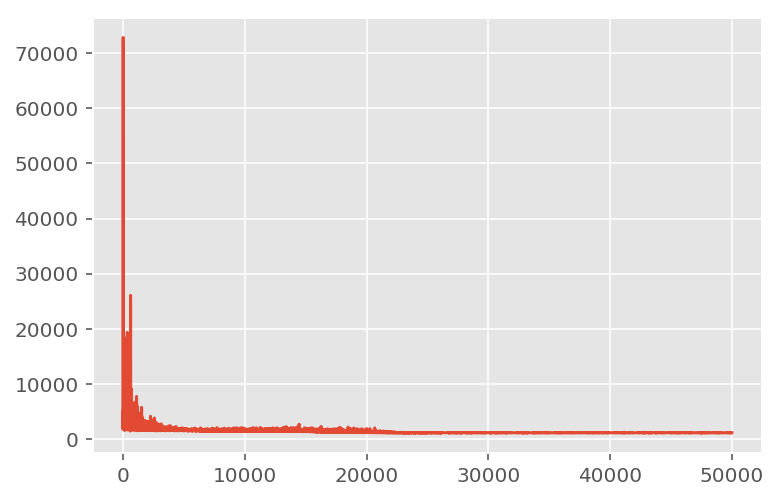

In [255]:
plt.plot(advi_fr.hist);

## FullRankADVI via pm.fit()

In [261]:
with model:
    advi_fr2 = pm.fit(n=50000, method='fullrank_advi', obj_optimizer=pm.adagrad(learning_rate=1e-1))

Average Loss = 1,321.5: 100%|██████████| 50000/50000 [02:52<00:00, 289.66it/s]
Finished [100%]: Average Loss = 1,321.4


In [262]:
with model:
    advi_fr3 = pm.fit(n=50000, method='fullrank_advi')

Average Loss = 1,078.9: 100%|██████████| 50000/50000 [02:53<00:00, 287.45it/s]
Finished [100%]: Average Loss = 1,078.9


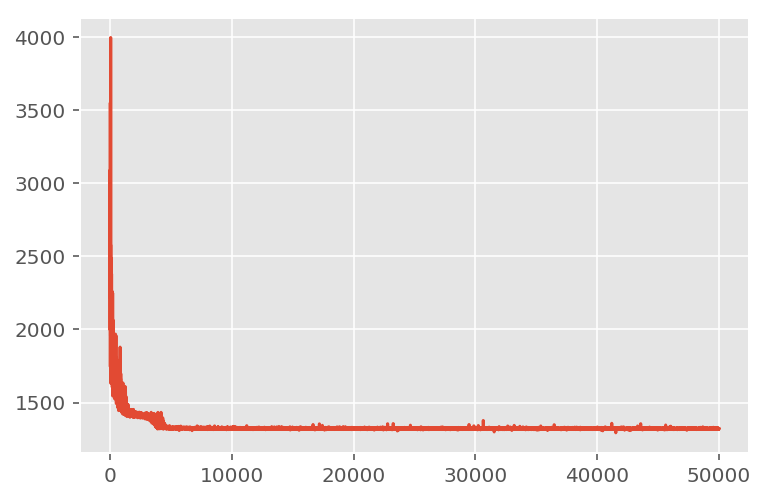

In [263]:
plt.plot(advi_fr2.hist);

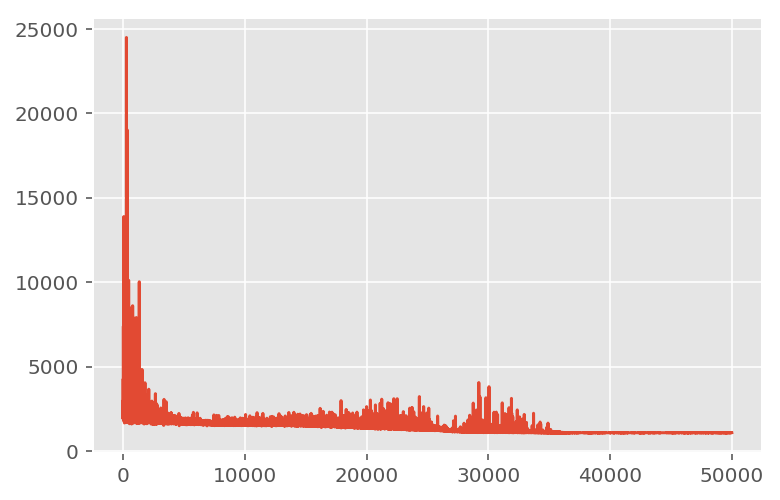

In [264]:
plt.plot(advi_fr3.hist)

## ADVI via pm.ADVI()

In [265]:
with model:
    advi_mf=pm.ADVI()
    advi_mf.fit(50000)

Average Loss = 1,078.5: 100%|██████████| 50000/50000 [02:54<00:00, 287.23it/s]
Finished [100%]: Average Loss = 1,078.5


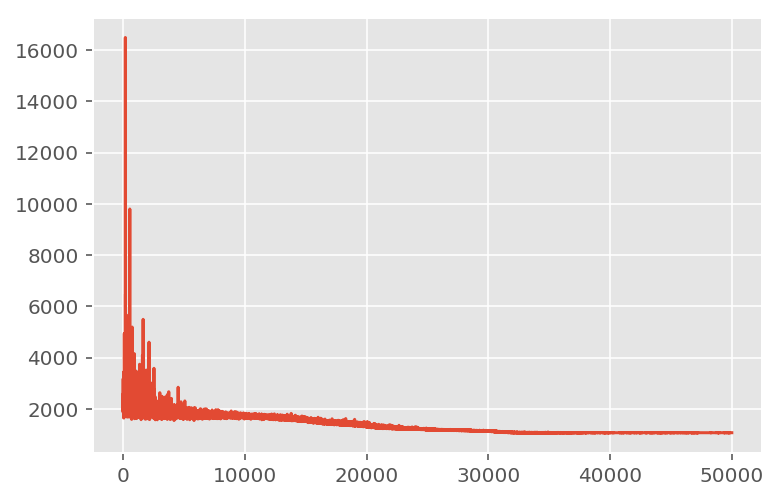

In [268]:
plt.plot(advi_mf.hist);

## ADVI via pm.fit()

In [266]:
with model:
    advi_mf2 = pm.fit(n=50000, obj_optimizer=pm.adagrad(learning_rate=1e-1))

Average Loss = 1,078.3: 100%|██████████| 50000/50000 [02:44<00:00, 327.53it/s]
Finished [100%]: Average Loss = 1,078.3


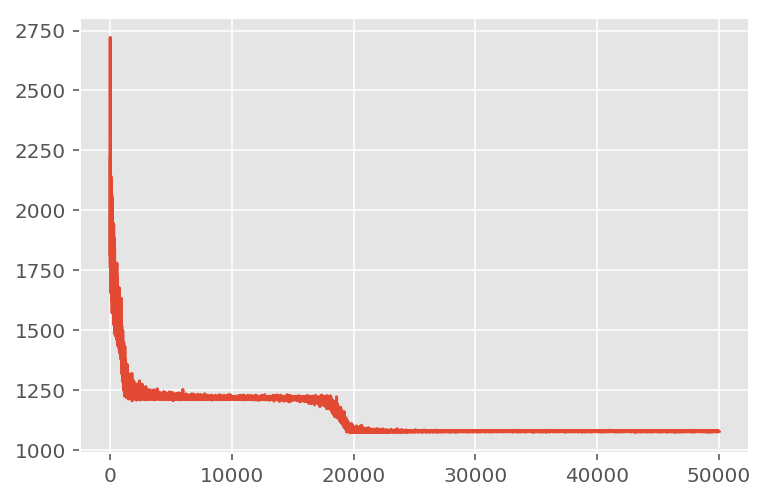

In [269]:
plt.plot(advi_mf2.hist);

# Criticism

## PDI

based on paper http://proceedings.mlr.press/v70/kucukelbir17a/kucukelbir17a.pdf

In [271]:
from pymc3.stats import _log_post_trace
def PDI(trace, model):
    log_px = _log_post_trace(trace, model) # shape (nsamples, N_datapoints)
    
    # log posterior predictive density of data point n = E_{q(\theta)} p(x_n|\theta) 
    lppd_n = sp_logsumexp(log_px, axis=0, b=1.0 / log_px.shape[0])
    
    mu_n = np.exp(lppd_n)
    
    var_log_n = np.var(log_px, axis=0)
    
    mu_log_n = np.mean(log_px, axis=0)
    
    var_n = np.var(np.exp(log_px), axis=0)
    
    pdi = np.divide(var_n, mu_n)
    pdi_log = np.divide(var_log_n, mu_log_n)
    
    wapdi = np.divide(var_log_n, mu_n)
    
    return pdi, pdi_log, wapdi

# PSIS
based on https://github.com/junpenglao/Planet_Sakaar_Data_Science/blob/master/WIP/%5BWIP%5D%20Comparing%20VI%20approximation.ipynb

In [272]:
#PSIS
from pymc3.math import logsumexp
from scipy.special import logsumexp as sp_logsumexp
from pymc3.distributions.dist_math import rho2sd

def log_important_ratio(approx, nsample):
    logp_func = approx.model.logp

    # in ADVI there are only 1 group approximation
    approx_group = approx.groups[0]
    if approx.short_name == "mean_field":
        mu_q = approx_group.params[0].eval()
        std_q = rho2sd(approx_group.params[1]).eval()
        logq_func = st.norm(mu_q, std_q)
    elif approx.short_name == "full_rank":
        packed_chol_q = approx_group.params[0]
        mu_q = approx_group.params[1].eval()
        dim = mu_q.shape[0]
        chol_q = pm.expand_packed_triangular(dim, packed_chol_q, lower=True).eval()
        cov_q = np.dot(chol_q, chol_q.T)
        logq_func = st.multivariate_normal(mu_q, cov_q)
        
    dict_to_array = approx_group.bij.map

    p_theta_y = []
    q_theta = []
    samples = approx.sample_dict_fn(nsample)  # type: dict
    points = ({name: records[i] for name, records in samples.items()}
              for i in range(nsample))

    for point in points:
        p_theta_y.append(logp_func(point))
        q_theta.append(np.sum(logq_func.logpdf(dict_to_array(point))))
    p_theta_y = np.asarray(p_theta_y)
    q_theta = np.asarray(q_theta)
    return p_theta_y-q_theta


In [276]:
nsample = 10000
ratio_advi_mf = log_important_ratio(advi_mf.approx, nsample)
_, k = pm.stats._psislw(ratio_advi_mf[:, None], 1)
k

array([0.17293144])

In [275]:
ratio_advi_mf2 = log_important_ratio(advi_mf2, nsample)
_, k2 = pm.stats._psislw(ratio_advi_mf2[:, None], 1)
k2

array([0.42639058])

In [279]:
ratio_advi_fr = log_important_ratio(advi_fr.approx, nsample)
_, k_fr = pm.stats._psislw(ratio_advi_fr[:, None], 1)
k_fr

array([0.9365361])

In [282]:
ratio_advi_fr2 = log_important_ratio(advi_fr2, nsample)
_, k_fr2 = pm.stats._psislw(ratio_advi_fr2[:, None], 1)
k_fr2

array([1.37102098])